# https://github.com/openai/gym/blob/master/gym/core.py


```Python

from gym import logger

import gym
from gym import error
from gym.utils import closer

env_closer = closer.Closer()


class Env(object):
    """The main OpenAI Gym class. It encapsulates an environment with
    arbitrary behind-the-scenes dynamics. An environment can be
    partially or fully observed.
    The main API methods that users of this class need to know are:
        step
        reset
        render
        close
        seed
    And set the following attributes:
        action_space: The Space object corresponding to valid actions
        observation_space: The Space object corresponding to valid observations
        reward_range: A tuple corresponding to the min and max possible rewards
    Note: a default reward range set to [-inf,+inf] already exists. Set it if you want a narrower range.
    The methods are accessed publicly as "step", "reset", etc.. The
    non-underscored versions are wrapper methods to which we may add
    functionality over time.
    """

    # Set this in SOME subclasses
    metadata = {'render.modes': []}
    reward_range = (-float('inf'), float('inf'))
    spec = None

    # Set these in ALL subclasses
    action_space = None
    observation_space = None

    def step(self, action):
        """Run one timestep of the environment's dynamics. When end of
        episode is reached, you are responsible for calling `reset()`
        to reset this environment's state.
        Accepts an action and returns a tuple (observation, reward, done, info).
        Args:
            action (object): an action provided by the environment
        Returns:
            observation (object): agent's observation of the current environment
            reward (float) : amount of reward returned after previous action
            done (boolean): whether the episode has ended, in which case further step() calls will return undefined results
            info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
        """
        raise NotImplementedError

    def reset(self):
        """Resets the state of the environment and returns an initial observation.
        Returns: observation (object): the initial observation of the
            space.
        """
        raise NotImplementedError

    def render(self, mode='human'):
        """Renders the environment.
        The set of supported modes varies per environment. (And some
        environments do not support rendering at all.) By convention,
        if mode is:
        - human: render to the current display or terminal and
          return nothing. Usually for human consumption.
        - rgb_array: Return an numpy.ndarray with shape (x, y, 3),
          representing RGB values for an x-by-y pixel image, suitable
          for turning into a video.
        - ansi: Return a string (str) or StringIO.StringIO containing a
          terminal-style text representation. The text can include newlines
          and ANSI escape sequences (e.g. for colors).
        Note:
            Make sure that your class's metadata 'render.modes' key includes
              the list of supported modes. It's recommended to call super()
              in implementations to use the functionality of this method.
        Args:
            mode (str): the mode to render with
        Example:
        class MyEnv(Env):
            metadata = {'render.modes': ['human', 'rgb_array']}
            def render(self, mode='human'):
                if mode == 'rgb_array':
                    return np.array(...) # return RGB frame suitable for video
                elif mode is 'human':
                    ... # pop up a window and render
                else:
                    super(MyEnv, self).render(mode=mode) # just raise an exception
        """
        raise NotImplementedError

    def close(self):
        """Override _close in your subclass to perform any necessary cleanup.
        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        return

    def seed(self, seed=None):
        """Sets the seed for this env's random number generator(s).
        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.
        Returns:
            list<bigint>: Returns the list of seeds used in this env's random
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        logger.warn("Could not seed environment %s", self)
        return

    @property
    def unwrapped(self):
        """Completely unwrap this env.
        Returns:
            gym.Env: The base non-wrapped gym.Env instance
        """
        return self

    def __str__(self):
        if self.spec is None:
            return '<{} instance>'.format(type(self).__name__)
        else:
            return '<{}<{}>>'.format(type(self).__name__, self.spec.id)

    def __enter__(self):
        return self

    def __exit__(self, *args):
        self.close()
        # propagate exception
        return False


class GoalEnv(Env):
    """A goal-based environment. It functions just as any regular OpenAI Gym environment but it
    imposes a required structure on the observation_space. More concretely, the observation
    space is required to contain at least three elements, namely `observation`, `desired_goal`, and
    `achieved_goal`. Here, `desired_goal` specifies the goal that the agent should attempt to achieve.
    `achieved_goal` is the goal that it currently achieved instead. `observation` contains the
    actual observations of the environment as per usual.
    """

    def reset(self):
        # Enforce that each GoalEnv uses a Goal-compatible observation space.
        if not isinstance(self.observation_space, gym.spaces.Dict):
            raise error.Error('GoalEnv requires an observation space of type gym.spaces.Dict')
        result = super(GoalEnv, self).reset()
        for key in ['observation', 'achieved_goal', 'desired_goal']:
            if key not in result:
                raise error.Error('GoalEnv requires the "{}" key to be part of the observation dictionary.'.format(key))
        return result

    def compute_reward(self, achieved_goal, desired_goal, info):
        """Compute the step reward. This externalizes the reward function and makes
        it dependent on an a desired goal and the one that was achieved. If you wish to include
        additional rewards that are independent of the goal, you can include the necessary values
        to derive it in info and compute it accordingly.
        Args:
            achieved_goal (object): the goal that was achieved during execution
            desired_goal (object): the desired goal that we asked the agent to attempt to achieve
            info (dict): an info dictionary with additional information
        Returns:
            float: The reward that corresponds to the provided achieved goal w.r.t. to the desired
            goal. Note that the following should always hold true:
                ob, reward, done, info = env.step()
                assert reward == env.compute_reward(ob['achieved_goal'], ob['goal'], info)
        """
        raise NotImplementedError()

warn_once = True

def deprecated_warn_once(text):
    global warn_once
    if not warn_once: return
    warn_once = False
    logger.warn(text)


class Wrapper(Env):
    env = None

    def __init__(self, env):
        self.env = env
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        self.reward_range = self.env.reward_range
        self.metadata = self.env.metadata
        self.spec = self.env.spec

    def __getattr__(self, name):
        if name.startswith('_'):
            raise AttributeError("attempted to get missing private attribute '{}'".format(name))
        return getattr(self.env, name)

    @classmethod
    def class_name(cls):
        return cls.__name__

    def step(self, action):
        if hasattr(self, "_step"):
            deprecated_warn_once("%s doesn't implement 'step' method, but it implements deprecated '_step' method." % type(self))
            self.step = self._step
            return self.step(action)
        else:
            deprecated_warn_once("%s doesn't implement 'step' method, " % type(self) +
                "which is required for wrappers derived directly from Wrapper. Deprecated default implementation is used.")
            return self.env.step(action)

    def reset(self, **kwargs):
        if hasattr(self, "_reset"):
            deprecated_warn_once("%s doesn't implement 'reset' method, but it implements deprecated '_reset' method." % type(self))
            self.reset = self._reset
            return self._reset(**kwargs)
        else:
            deprecated_warn_once("%s doesn't implement 'reset' method, " % type(self) +
                "which is required for wrappers derived directly from Wrapper. Deprecated default implementation is used.")
            return self.env.reset(**kwargs)

    def render(self, mode='human', **kwargs):
        return self.env.render(mode, **kwargs)

    def close(self):
        return self.env.close()

    def seed(self, seed=None):
        return self.env.seed(seed)

    def compute_reward(self, achieved_goal, desired_goal, info):
        return self.env.compute_reward(achieved_goal, desired_goal, info)

    def __str__(self):
        return '<{}{}>'.format(type(self).__name__, self.env)

    def __repr__(self):
        return str(self)

    @property
    def unwrapped(self):
        return self.env.unwrapped


class ObservationWrapper(Wrapper):
    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        return self.observation(observation), reward, done, info

    def reset(self, **kwargs):
        observation = self.env.reset(**kwargs)
        return self.observation(observation)

    def observation(self, observation):
        deprecated_warn_once("%s doesn't implement 'observation' method. Maybe it implements deprecated '_observation' method." % type(self))
        return self._observation(observation)


class RewardWrapper(Wrapper):
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        return observation, self.reward(reward), done, info

    def reward(self, reward):
        deprecated_warn_once("%s doesn't implement 'reward' method. Maybe it implements deprecated '_reward' method." % type(self))
        return self._reward(reward)


class ActionWrapper(Wrapper):
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def step(self, action):
        action = self.action(action)
        return self.env.step(action)

    def action(self, action):
        deprecated_warn_once("%s doesn't implement 'action' method. Maybe it implements deprecated '_action' method." % type(self))
        return self._action(action)

    def reverse_action(self, action):
        deprecated_warn_once("%s doesn't implement 'reverse_action' method. Maybe it implements deprecated '_reverse_action' method." % type(self))
        return self._reverse_action(action)
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from gym import Env, spaces
from gym.utils import seeding

REGISTER_FLG=0

In [2]:
def categorical_sample(prob_n, np_random):
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np_random.rand()).argmax()


class DiscreteEnv(Env):

    """
    Has the following members
    - nS: number of states
    - nA: number of actions
    - P: transitions (*)
    - isd: initial state distribution (**)
    (*) dictionary dict of dicts of lists, where
      P[s][a] == [(probability, nextstate, reward, done), ...]
    (**) list or array of length nS
    """
    def __init__(self, nS, nA, P, isd):
        self.P = P
        #print(P)
        self.isd = isd
        self.lastaction = None # for rendering
        self.nS = nS
        self.nA = nA

        self.action_space = spaces.Discrete(self.nA)
        self.observation_space = spaces.Discrete(self.nS)

        self.seed()
        self.s = categorical_sample(self.isd, self.np_random)
        self.lastaction=None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.s = categorical_sample(self.isd, self.np_random)
        #print(self.isd,self.np_random,self.s)
        self.lastaction = None
        return self.s

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, d= transitions[i]
        self.s = s
        self.lastaction = a
        return (s, r, d, {"prob" : p})

    def step2(self, a):
        transitions = self.P[self.s][a]
        return transitions
    


In [3]:
import sys
from contextlib import closing

import numpy as np
from six import StringIO, b

from gym import utils
from gym.envs.toy_text import discrete
# action
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
# map
MAPS = {
    "4x4": [
        "FFFG",
        "FHFH",
        "FFFF",
        "SFFF"
    ],
}
#  0  1  2  3
#  4  5  6  7
#  8  9 10 11
# 12 13 14 15
def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # BFS to check that it's a valid path.
    def is_valid(arr, r=0, c=0):
        if arr[r][c] == 'G':
            return True

        tmp = arr[r][c]
        arr[r][c] = "#"

        # Recursively check in all four directions.
        directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
        for x, y in directions:
            r_new = r + x
            c_new = c + y
            if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                continue

            if arr[r_new][c_new] not in '#H':
                if is_valid(arr, r_new, c_new):
                    arr[r][c] = tmp
                    return True

        arr[r][c] = tmp
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, desc=None, map_name="4x4",is_slippery=True):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc,dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()

        P = {s : {a : [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row*ncol + col
        
        def inc(row, col, a):
            if a == LEFT:
                col = max(col-1,0)
            elif a == DOWN:
                row = min(row+1,nrow-1)
            elif a == RIGHT:
                col = min(col+1,ncol-1)
            elif a == UP:
                row = max(row-1,0)
            return (row, col)

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'GH':
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a-1)%4, a, (a+1)%4]:
                                newrow, newcol = inc(row, col, b)
                                newstate = to_s(newrow, newcol)
                                newletter = desc[newrow, newcol]
                                done = bytes(newletter) in b'GH'
                                rew = float(newletter == b'G')
                                li.append((1.0/3.0, newstate, rew, done))
                        else:
                            newrow, newcol = inc(row, col, a)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow, newcol]
                            done = bytes(newletter) in b'GH'
                            rew = float(newletter == b'G')
                            li.append((1.0, newstate, rew, done))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Left","Down","Right","Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()

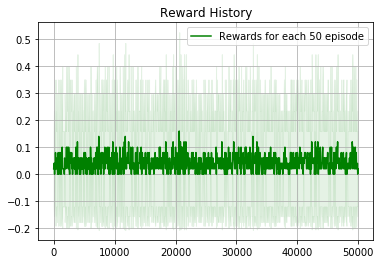

In [4]:
class RandAgent():

    def __init__(self, epsilon):
        self.Q = {}
        self.epsilon = epsilon
        self.reward_log = []

    def policy(self, s, actions):
        return np.random.randint(len(actions))

    def init_log(self):
        self.reward_log = []

    def log(self, reward):
        self.reward_log.append(reward)

    def show_reward_log(self, interval=50, episode=-1):
        if episode > 0:
            rewards = self.reward_log[-interval:]
            mean = np.round(np.mean(rewards), 3)
            std = np.round(np.std(rewards), 3)
            print("At Episode {} average reward is {} (+/-{}).".format(
                   episode, mean, std))
        else:
            indices = list(range(0, len(self.reward_log), interval))
            means = []
            stds = []
            for i in indices:
                rewards = self.reward_log[i:(i + interval)]
                means.append(np.mean(rewards))
                stds.append(np.std(rewards))
            means = np.array(means)
            stds = np.array(stds)
            plt.figure()
            plt.title("Reward History")
            plt.grid()
            plt.fill_between(indices, means - stds, means + stds,
                             alpha=0.1, color="g")
            plt.plot(indices, means, "-", color="g",
                     label="Rewards for each {} episode".format(interval))
            plt.legend(loc="best")
            plt.show()

from collections import defaultdict
import gym

class RandamAgent(RandAgent):

    def __init__(self, epsilon=0.1):
        super().__init__(epsilon)

    def learn(self, env, episode_count=1000, gamma=0.9,
              learning_rate=0.1, render=False, report_interval=50):
        self.init_log()
        actions = list(range(env.action_space.n))
        for e in range(episode_count):
            s = env.reset()
            done = False
            a=0
            while not done:
                if render:
                    env.render()
                a = self.policy(s, actions)
                n_state, reward, done, info = env.step(a) #ランダムにaをスリップ
                s = n_state
            else:
                self.log(reward)

def train():
    agent = RandamAgent()
    env = gym.make("FrozenLakeEasy-v0") #gym
    agent.learn(env, episode_count=50000)
    agent.show_reward_log()

from gym.envs.registration import register
if REGISTER_FLG==0:
    register(id="FrozenLakeEasy-v0", entry_point=FrozenLakeEnv,kwargs={"is_slippery": False})    
    REGISTER_FLG+=1

if __name__ == "__main__":
    train()

In [5]:
def V(s, gamma=0.99):
    V = R(s) + gamma * max_V_on_next_state(s)
    return V


def R(s):# 終了時の価値である。これがないとVは何時でもゼロになる。
    if s == "happy_end":
        return 1
    elif s == "bad_end":
        return -1
    else:
        return 0

def max_V_on_next_state(s):
    # If game end, expected value is 0.
    if s in ["happy_end", "bad_end"]:#endであれば次の状態はない
        return 0

    actions = ["up", "down"]
    values = []
    for a in actions:# a=upであってもdownになる確率もあるということに注意
        transition_probs = transit_func(s, a) # transition_probs={"state_up":0.7,"state_down",0.3}
        v = 0
        for next_state in transition_probs: #いつでもupとdownについて計算して確率をかけているのでvは期待値
            #print(transition_probs,next_state)
            prob = transition_probs[next_state]
            v += prob * V(next_state) # vは期待値---Vまたはmax_V_on_next_stateが入れ子になっているのでこの先には
            #max_V_on_next_stateが終了しない限り進みません。for文はおわりません。
            #print(v)
        values.append(v)
    return max(values)

# 入れ子を通して次の状態をしらみつぶしに計算しています。upとdownの木構造を作っています。

def transit_func(s, a):
    """
    Make next state by adding action str to state.
    ex: (s = 'state', a = 'up') => 'state_up'
        (s = 'state_up', a = 'down') => 'state_up_down'
    """

    actions = s.split("_")[1:]
    LIMIT_GAME_COUNT = 5
    HAPPY_END_BORDER = 4
    MOVE_PROB = 0.9

    def next_state(state, action):
        return "_".join([state, action])

    if len(actions) == LIMIT_GAME_COUNT:
        up_count = sum([1 if a == "up" else 0 for a in actions])
        state = "happy_end" if up_count >= HAPPY_END_BORDER else "bad_end"
        prob = 1.0
        return {state: prob}
    else:
        opposite = "up" if a == "down" else "down"
        return {
            next_state(s, a): MOVE_PROB,
            next_state(s, opposite): 1 - MOVE_PROB
        }


if __name__ == "__main__":
    print(V("state"))


0.7880942034605892


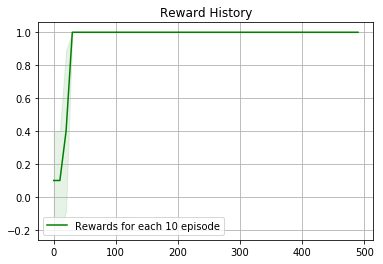

In [11]:
class Planner():

    def __init__(self, epsilon):
        self.Q = {}
        self.epsilon = epsilon
        self.reward_log = []

    def policy(self, s, actions):
        if s in self.Q and sum(self.Q[s]) != 0:
            return np.argmax(self.Q[s])
        else:
            return np.random.randint(len(actions))        

    def init_log(self):
        self.reward_log = []

    def log(self, reward):
        self.reward_log.append(reward)

    def show_reward_log(self, interval=10, episode=-1):
        if episode > 0:
            rewards = self.reward_log[-interval:]
            mean = np.round(np.mean(rewards), 3)
            std = np.round(np.std(rewards), 3)
            print("At Episode {} average reward is {} (+/-{}).".format(
                   episode, mean, std))
        else:
            indices = list(range(0, len(self.reward_log), interval))
            means = []
            stds = []
            for i in indices:
                rewards = self.reward_log[i:(i + interval)]
                means.append(np.mean(rewards))
                stds.append(np.std(rewards))
            means = np.array(means)
            stds = np.array(stds)
            plt.figure()
            plt.title("Reward History")
            plt.grid()
            plt.fill_between(indices, means - stds, means + stds,
                             alpha=0.1, color="g")
            plt.plot(indices, means, "-", color="g",
                     label="Rewards for each {} episode".format(interval))
            plt.legend(loc="best")
            plt.show()

from collections import defaultdict
import gym

class PlanningAgent(Planner):

    def __init__(self, epsilon=0.1):
        super().__init__(epsilon)

    def learn(self, env, episode_count=1000, gamma=0.9,threshold=0.00001,
              learning_rate=0.1, render=False, report_interval=50):
        self.init_log()
        self.V=np.zeros(env.nS)
        actions = list(range(env.action_space.n))
        self.Q = defaultdict(lambda: [0] * len(actions))#n_stateの4方向actionの価値
        while True:
            delta=0
            for s in range(env.nS):
                gain=0
                expected_rewards=[]
                for a in actions:
                    env.s=s
                    transitions = env.step2(a) #ランダムにaをスリップ
                    for info,n_state, reward, done in transitions:
                        gain += info*(reward+gamma*self.V[n_state])*(not done)
                    expected_rewards.append(gain)
                max_reward=max(expected_rewards)
                best_action=np.argmax(expected_rewards)
                delta=max(delta,abs(max_reward-self.V[s]))
                self.V[s]=max_reward
                self.Q[s][best_action]
            if delta<threshold:
                break
                
        for e in range(episode_count):
            s = env.reset()
            done = False
            while not done:
                if render:
                    env.render()
                a = self.policy(s, actions)
                n_state, reward, done,info = env.step(a) #ランダムにaをスリップ
                gain = reward + gamma * max(self.Q[n_state])
                estimated = self.Q[s][a]
                self.Q[s][a] += learning_rate * (gain - estimated)
                s = n_state

            else:
                self.log(reward)


def train():
    agent = PlanningAgent()
    env = gym.make("FrozenLakeEasy-v0") #gym
    agent.learn(env, episode_count=500)
    agent.show_reward_log()

if __name__ == "__main__":
    train()